In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
from numpy import unique
from numpy import where
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype

import seaborn as sns
import os
import pandas as pd
import numpy as np
import cartopy.crs as crs
import cartopy.feature as cfeature

Matplotlib created a temporary config/cache directory at /tmp/tmp.tQDiCOvZUq/matplotlib-gv14vnof because the default path (/home/aevans/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# get lons and lats
# This will return the most recent data avail on mesonet
# this is my file path
ny_mesonet_data_path = "/home/aevans/nysm/archive/nysm/netcdf/proc/"
ok_mesonet_data_path = "/home/aevans/landtype/geoinfo.csv"

In [4]:
# create a dataframe of mesonet data ok
ok_df = pd.read_csv(ok_mesonet_data_path)

In [5]:
ok_df_lons = ok_df["elon"].to_list()
ok_df_lats = ok_df["nlat"].to_list()

In [6]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["color"],
        s=40,
        marker="o",
        transform=crs.PlateCarree(),
    )
    ax.set_title("Mesonet Site Groups", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [7]:
df = pd.read_csv("/home/aevans/landtype/data/buffer_10_km/avg_lulc_ok_10.csv")

In [8]:
# exclude the categorical columns
features = df.drop(
    ["station", "Unnamed: 0", "firstmode_class", "secondmode_class", "thirdmode_class"],
    axis=1,
)

In [9]:
cor = features.corr()

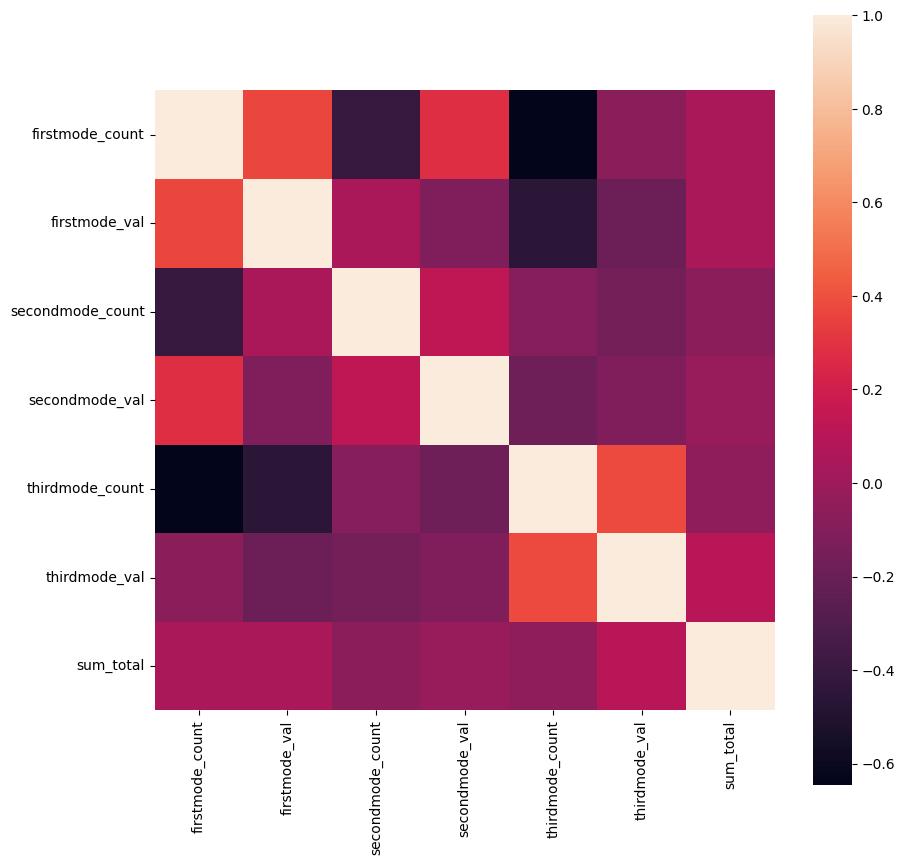

In [10]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor, square=True)
plt.show()

In [11]:
scaler = StandardScaler()
X_std = scaler.fit_transform(features)

In [12]:
clt = AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")

In [13]:
model = clt.fit(X_std)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  14


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [14]:
clusters = pd.DataFrame(model.fit_predict(X_std))
features["Cluster"] = clusters

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [16]:
stations = df["station"]
stations = pd.concat((stations, features), axis=1)
stations = stations.rename({"station": "station", 0: "Cluster"}, axis=1)
sortstations = stations.sort_values(["station"])
sortstations["lon"] = ok_df_lons
sortstations["lat"] = ok_df_lats

In [17]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations["color"] = sortstations["Cluster"].map(colordict)

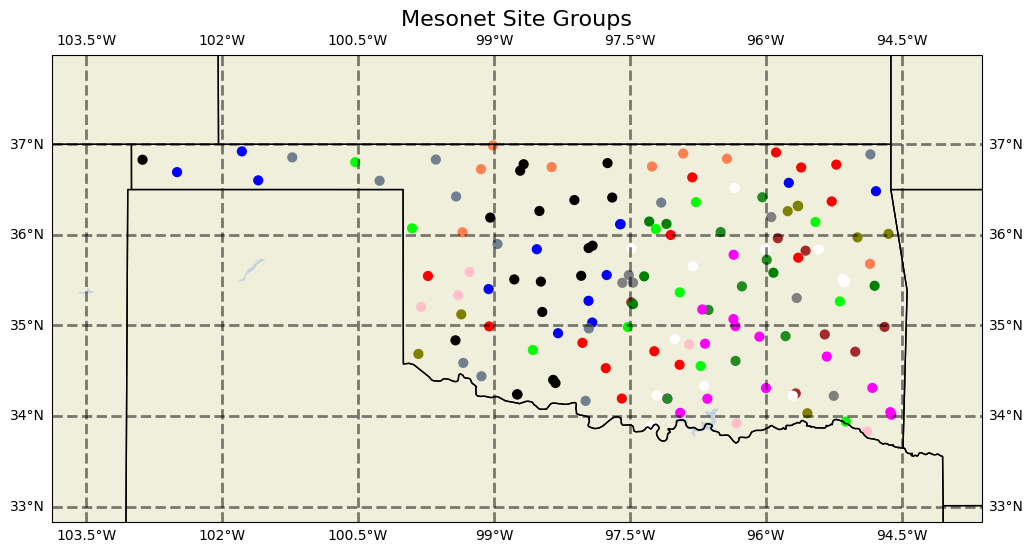

In [18]:
plurality_plot(sortstations)

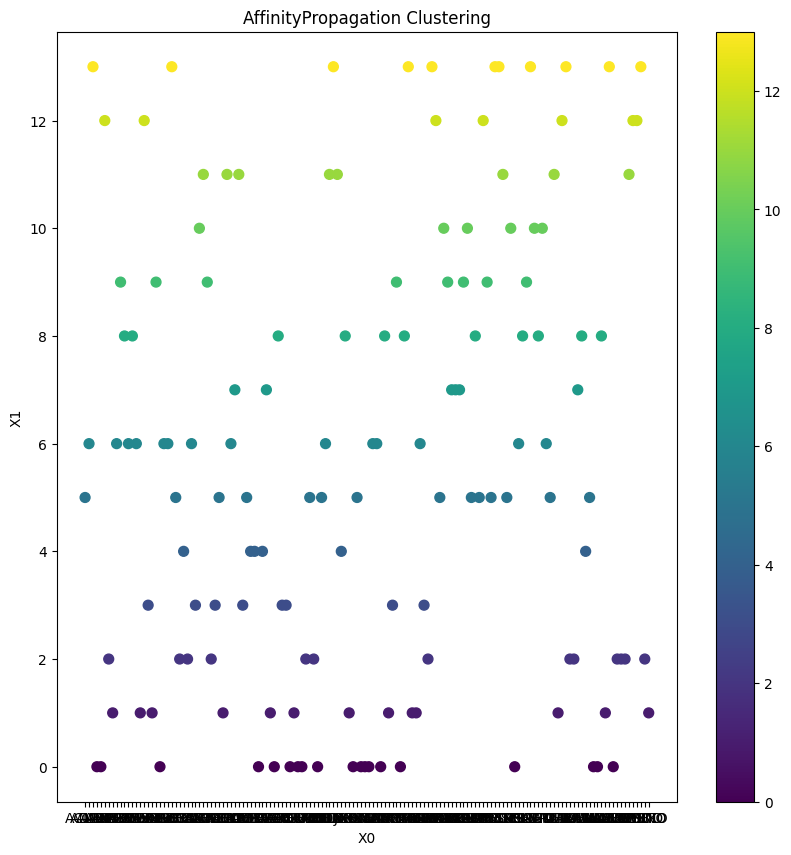

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(
    sortstations["station"], sortstations["Cluster"], c=sortstations["Cluster"], s=50
)
ax.set_title("AffinityPropagation Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

# let's cluster on elevation

In [20]:
elev_df = pd.read_csv("/home/aevans/landtype/elevation/data/OK/elev/ok30_df.csv")
elev_df.head()

,Unnamed: 0,station,elev,std,variance,skew,med_dist,lon,lat
0,0,ACME,397,28.782149,828.118766,0.168916,422.0,-98.02325,34.80833
1,1,ADAX,295,44.364079,1967.475770,0.239160,304.0,-96.66909,34.79851
2,2,ALTU,416,27.111264,734.760977,0.556609,412.0,-99.33808,34.58722
3,3,ALV2,439,39.008927,1521.158657,0.418186,437.0,-98.70974,36.70823
4,4,ALVA,450,44.431868,1973.492057,0.321617,461.0,-98.67170,36.77970


In [21]:
# exclude the categorical columns
features_elev = elev_df.drop(["station", "Unnamed: 0", "lon", "lat"], axis=1)

In [22]:
cor_e = features_elev.corr()

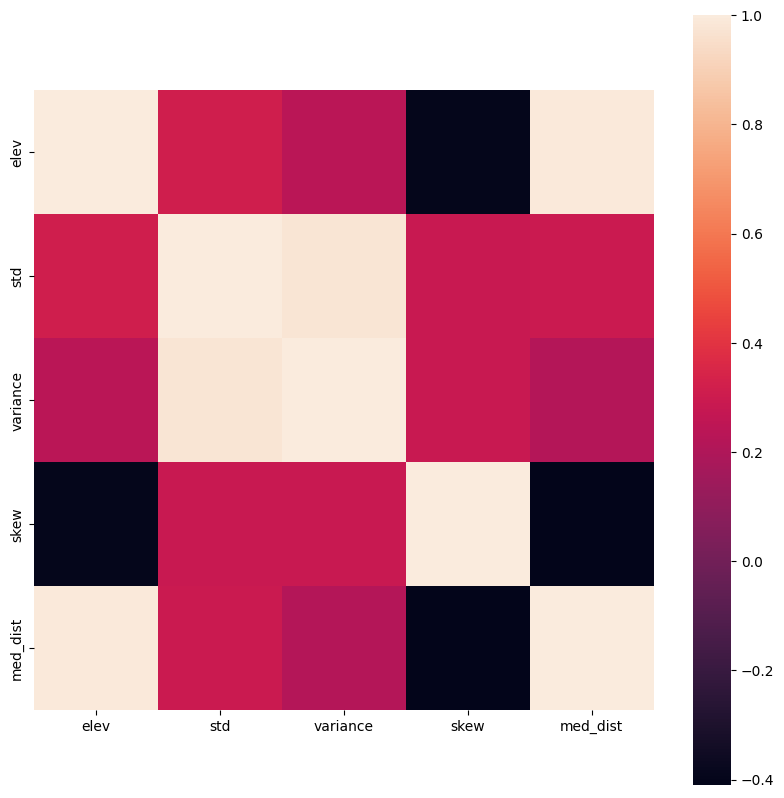

In [23]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor_e, square=True)
plt.show()

In [24]:
scaler = StandardScaler()
X_std_e = scaler.fit_transform(features_elev)

In [25]:
clt_e = AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")

In [26]:
model = clt_e.fit(X_std_e)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  15


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [27]:
clusters_e = pd.DataFrame(model.fit_predict(X_std_e))
features_elev["Cluster"] = clusters_e

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [28]:
features_elev.head()

,elev,std,variance,skew,med_dist,Cluster
0,397,28.782149,828.118766,0.168916,422.0,14
1,295,44.364079,1967.475770,0.239160,304.0,13
2,416,27.111264,734.760977,0.556609,412.0,14
3,439,39.008927,1521.158657,0.418186,437.0,1
4,450,44.431868,1973.492057,0.321617,461.0,1


In [30]:
stations_elev = elev_df["station"]
stations_elev = pd.concat((stations_elev, features_elev), axis=1)
stations_elev = stations_elev.rename({"station": "station", 0: "Cluster"}, axis=1)
sortstations_e = stations_elev.sort_values(["station"])
sortstations_e["lon"] = ok_df_lons
sortstations_e["lat"] = ok_df_lats

In [31]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations_e["color"] = sortstations_e["Cluster"].map(colordict)

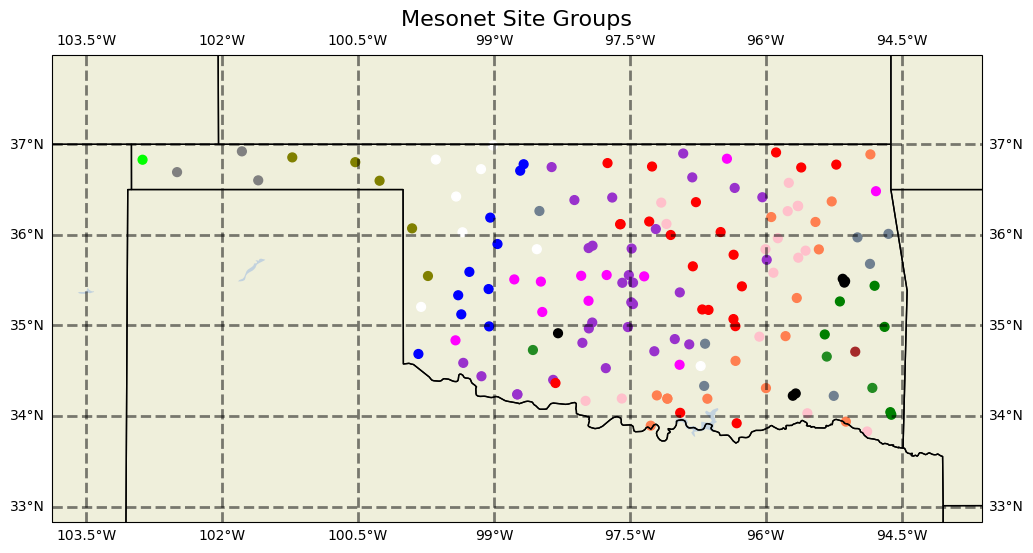

In [32]:
plurality_plot(sortstations_e)

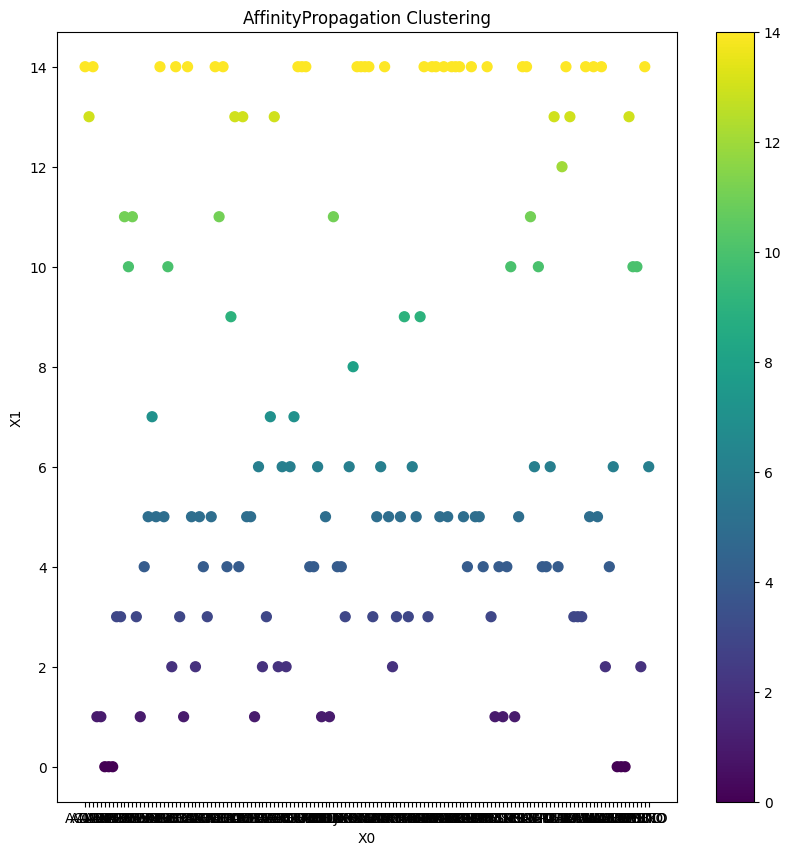

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(
    sortstations_e["station"],
    sortstations_e["Cluster"],
    c=sortstations_e["Cluster"],
    s=50,
)
ax.set_title("AffinityPropagation Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

# Let's Cluster on Slope

In [34]:
slope_df = pd.read_csv("/home/aevans/landtype/elevation/data/OK/elev/slope30_ok_df.csv")
slope_df.head()

,Unnamed: 0,Station,Mode,Count,Sum_total,Divide,Direction,Slope,color,lon,lat
0,0,ACME,19,2824.0,2824.0,100.000000,NaN,NaN,grey,-98.02325,34.80833
1,1,ADAX,19,2711.0,2711.0,100.000000,NaN,NaN,grey,-96.66909,34.79851
2,2,ALTU,25,1.0,2789.0,0.035855,S,LOW,lightpink,-99.33808,34.58722
3,3,ALV2,19,2805.0,2805.0,100.000000,NaN,NaN,grey,-98.70974,36.70823
4,4,ALVA,19,2801.0,2801.0,100.000000,NaN,NaN,grey,-98.67170,36.77970


In [35]:
# exclude the categorical columns
features_slope = slope_df.drop(
    ["Station", "Unnamed: 0", "Direction", "Slope", "color"], axis=1
)

In [36]:
cor_s = features_slope.corr()

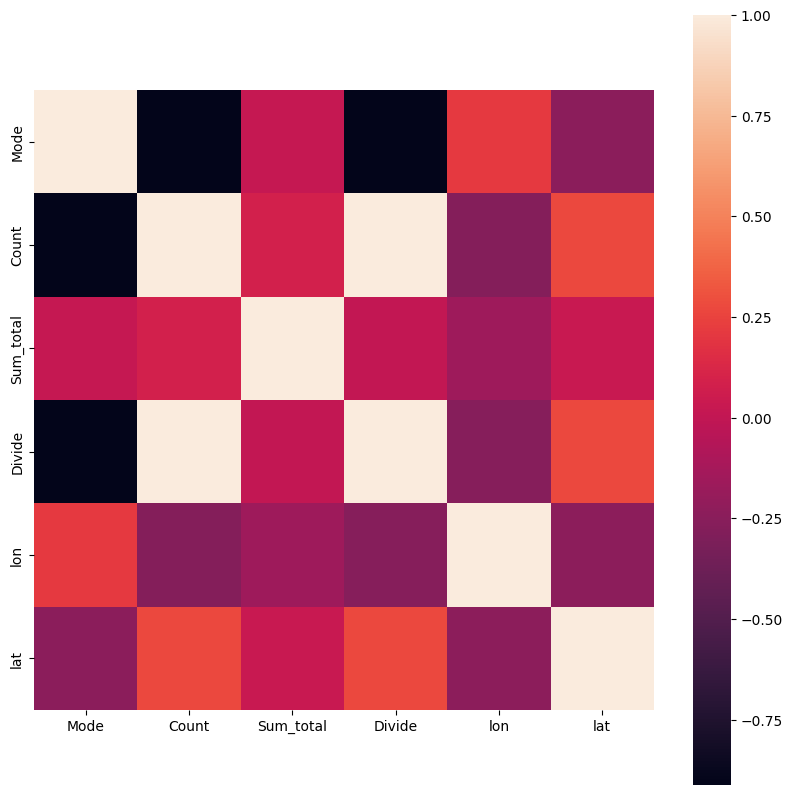

In [37]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor_s, square=True)
plt.show()

In [38]:
scaler = StandardScaler()
X_std_s = scaler.fit_transform(features_slope)

In [39]:
clt_s = AffinityPropagation(damping=0.5, max_iter=500, affinity="euclidean")

In [40]:
model = clt_s.fit(X_std_s)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  14


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [41]:
clusters_s = pd.DataFrame(model.fit_predict(X_std_s))
features_slope["Cluster"] = clusters_s

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [42]:
features_slope.head()

,Mode,Count,Sum_total,Divide,lon,lat,Cluster
0,19,2824.0,2824.0,100.000000,-98.02325,34.80833,8
1,19,2711.0,2711.0,100.000000,-96.66909,34.79851,6
2,25,1.0,2789.0,0.035855,-99.33808,34.58722,7
3,19,2805.0,2805.0,100.000000,-98.70974,36.70823,5
4,19,2801.0,2801.0,100.000000,-98.67170,36.77970,5


In [44]:
stations_slope = slope_df["Station"]
stations_slope = pd.concat((stations_slope, features_slope), axis=1)
stations_slope = stations_slope.rename({"Station": "station", 0: "Cluster"}, axis=1)
sortstations_s = stations_slope.sort_values(["station"])
sortstations_e["lon"] = ok_df_lons
sortstations_e["lat"] = ok_df_lats

In [45]:
sortstations_s.head()

,station,Mode,Count,Sum_total,Divide,lon,lat,Cluster
0,ACME,19,2824.0,2824.0,100.000000,-98.02325,34.80833,8
1,ADAX,19,2711.0,2711.0,100.000000,-96.66909,34.79851,6
2,ALTU,25,1.0,2789.0,0.035855,-99.33808,34.58722,7
3,ALV2,19,2805.0,2805.0,100.000000,-98.70974,36.70823,5
4,ALVA,19,2801.0,2801.0,100.000000,-98.67170,36.77970,5


In [46]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations_s["color"] = sortstations_s["Cluster"].map(colordict)

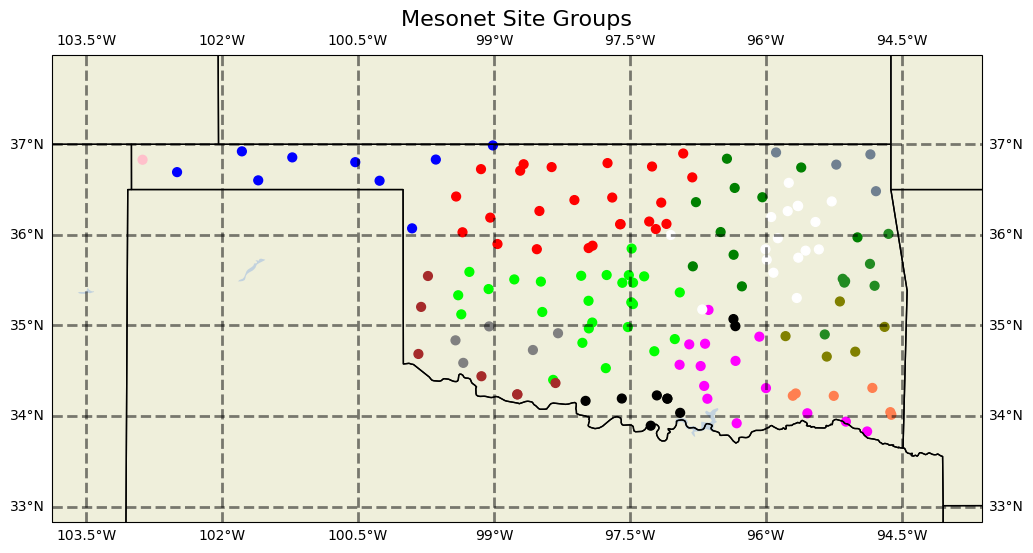

In [47]:
plurality_plot(sortstations_s)

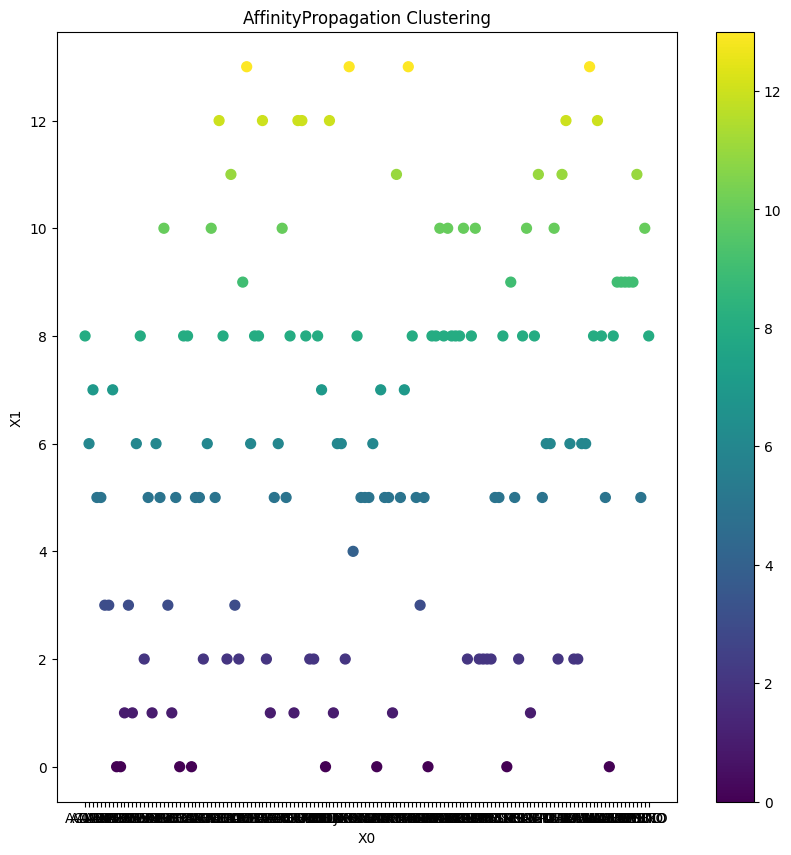

In [48]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(
    sortstations_s["station"],
    sortstations_s["Cluster"],
    c=sortstations_s["Cluster"],
    s=50,
)
ax.set_title("AffinityPropagation Clustering")
ax.set_xlabel("X0")
ax.set_ylabel("X1")
plt.colorbar(scatter)
plt.show()

# Let's try them all together

In [49]:
stations_ls = df["station"]

In [50]:
sortstations_s.head()

,station,Mode,Count,Sum_total,Divide,lon,lat,Cluster,color
0,ACME,19,2824.0,2824.0,100.000000,-98.02325,34.80833,8,lime
1,ADAX,19,2711.0,2711.0,100.000000,-96.66909,34.79851,6,magenta
2,ALTU,25,1.0,2789.0,0.035855,-99.33808,34.58722,7,gray
3,ALV2,19,2805.0,2805.0,100.000000,-98.70974,36.70823,5,red
4,ALVA,19,2801.0,2801.0,100.000000,-98.67170,36.77970,5,red


In [51]:
daddy = pd.merge(sortstations, sortstations_e, on="station")
dad_df = pd.merge(daddy, sortstations_s, on="station")
dad_df = dad_df.drop(
    columns=[
        "station",
        "Cluster_x",
        "Cluster",
        "Cluster_y",
        "lon",
        "lat",
        "lon_x",
        "lat_x",
        "lon_y",
        "lat_y",
        "color",
        "color_x",
        "color_y",
        "sum_total",
        "Sum_total",
        "Divide",
        "Count",
    ]
)
dad_df

,firstmode_count,firstmode_val,secondmode_count,secondmode_val,thirdmode_count,thirdmode_val,elev,std,variance,skew,med_dist,Mode
0,244513.0,71,58444.0,41,20559.0,82,397,28.782149,828.118766,0.168916,422.0,19
1,143041.0,41,111176.0,71,30651.0,81,295,44.364079,1967.475770,0.239160,304.0,19
2,265530.0,82,22744.0,52,14611.0,21,416,27.111264,734.760977,0.556609,412.0,25
3,203147.0,82,125532.0,71,8710.0,21,439,39.008927,1521.158657,0.418186,437.0,19
4,214942.0,82,104649.0,71,9651.0,21,450,44.431868,1973.492057,0.321617,461.0,19
...,...,...,...,...,...,...,...,...,...,...,...,...
139,105203.0,81,81657.0,41,67109.0,43,199,64.399898,4145.879818,1.304771,164.0,25
140,143265.0,81,60101.0,41,49083.0,43,143,77.106637,5943.328919,1.908500,98.0,21
141,260207.0,71,26063.0,82,15333.0,22,625,45.078786,2031.377586,0.261691,622.0,19
142,187776.0,71,100259.0,41,32093.0,81,269,28.158650,792.628867,0.187200,268.0,19


In [52]:
cor_d = dad_df.corr()

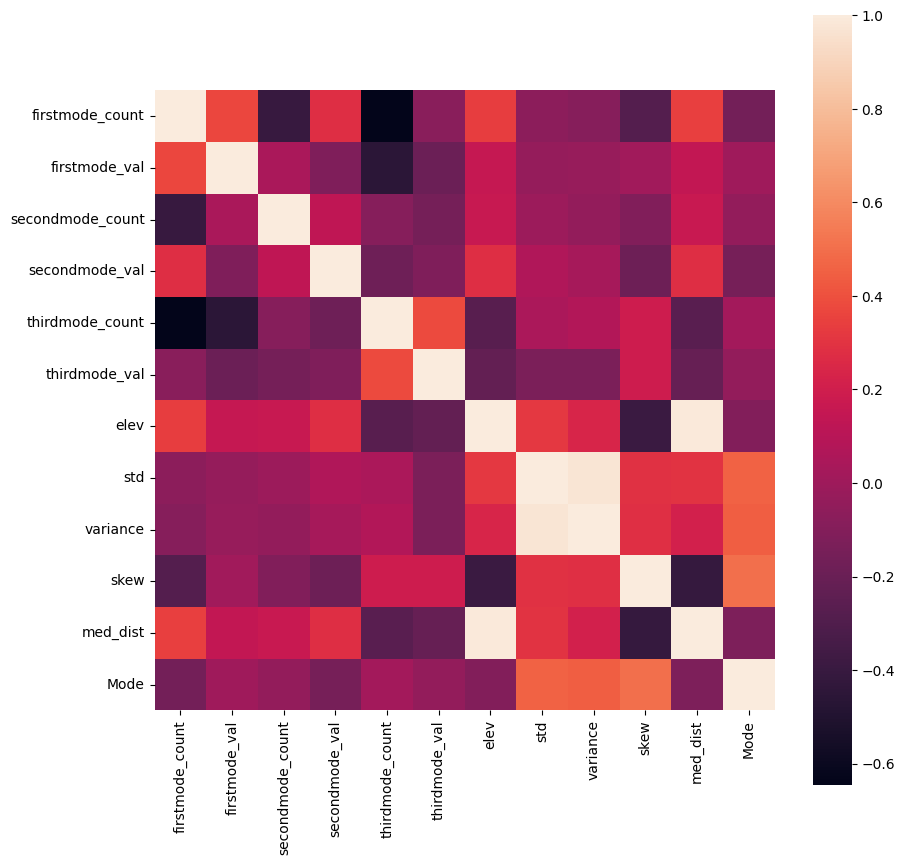

In [53]:
fig = plt.figure(figsize=(10, 10))
sns.heatmap(cor_d, square=True)
plt.show()

In [54]:
scaler = StandardScaler()
X_std_d = scaler.fit_transform(dad_df)

In [55]:
model = clt.fit(X_std_d)
n_clusters_ = len(model.cluster_centers_indices_)
print("Number of Clusters: ", n_clusters_)

Number of Clusters:  19


/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [56]:
clusters_d = pd.DataFrame(model.fit_predict(X_std_d))
dad_df["Cluster"] = clusters_d

/home/aevans/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [58]:
stations_d = df["station"]
stations_d = pd.concat((stations_d, dad_df), axis=1)
stations_d = stations_d.rename({"station": "station", 0: "Cluster"}, axis=1)
sortstations_d = stations_d.sort_values(["station"])
sortstations_d["lon"] = ok_df_lons
sortstations_d["lat"] = ok_df_lats

In [59]:
sortstations_d.head()

,station,firstmode_count,firstmode_val,secondmode_count,secondmode_val,thirdmode_count,thirdmode_val,elev,std,variance,skew,med_dist,Mode,Cluster,lon,lat
0,ACME,244513.0,71,58444.0,41,20559.0,82,397,28.782149,828.118766,0.168916,422.0,19,17,-98.02325,34.80833
1,ADAX,143041.0,41,111176.0,71,30651.0,81,295,44.364079,1967.475770,0.239160,304.0,19,3,-96.66909,34.79851
2,ALTU,265530.0,82,22744.0,52,14611.0,21,416,27.111264,734.760977,0.556609,412.0,25,0,-99.33808,34.58722
3,ALV2,203147.0,82,125532.0,71,8710.0,21,439,39.008927,1521.158657,0.418186,437.0,19,11,-98.70974,36.70823
4,ALVA,214942.0,82,104649.0,71,9651.0,21,450,44.431868,1973.492057,0.321617,461.0,19,11,-98.67170,36.77970


In [60]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortstations_d["color"] = sortstations_d["Cluster"].map(colordict)

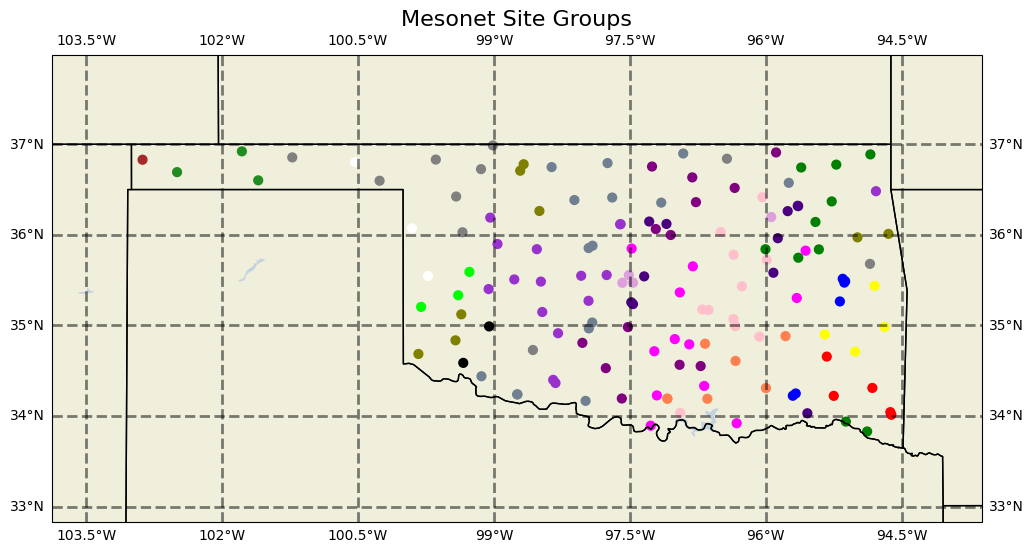

In [61]:
plurality_plot(sortstations_d)

In [64]:
for i in np.arange(0, 19):
    slopes_cat = sortstations_d.loc[sortstations_d["Cluster"] == i]
    slopes_cat = pd.merge(slopes_cat, daddy, on="station")
    slopes_cat.to_csv(f"/home/aevans/landtype/data/clean_cats/ok/aff/df_{i}.csv")

In [65]:
dirs = sorted(os.listdir("/home/aevans/landtype/data/clean_cats/ok/aff/"))

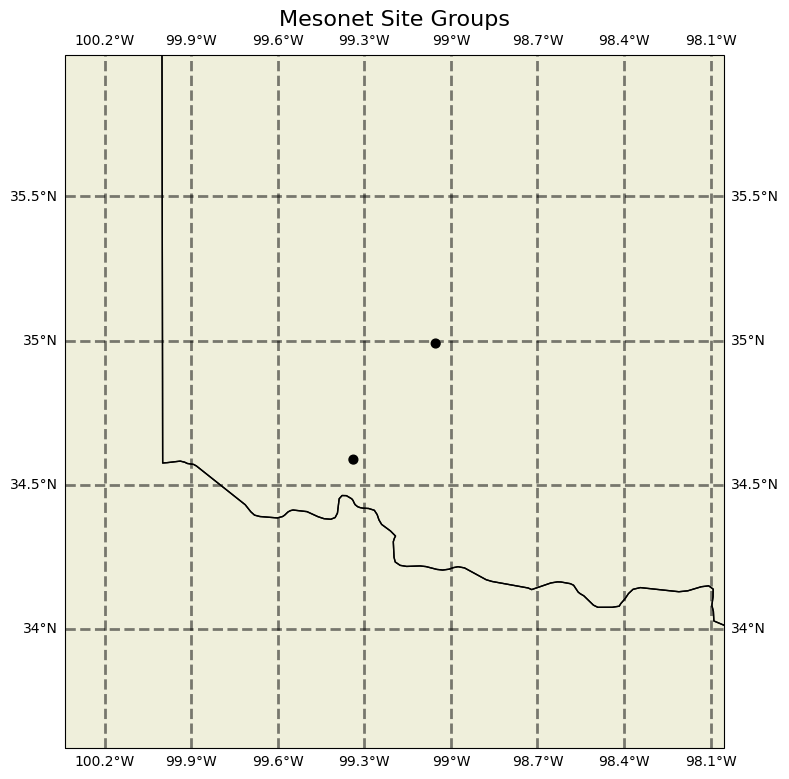

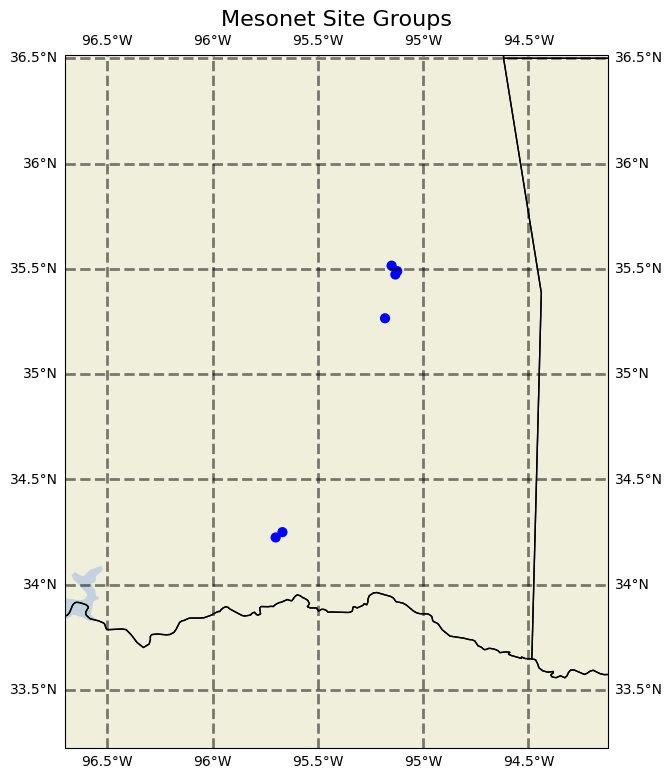

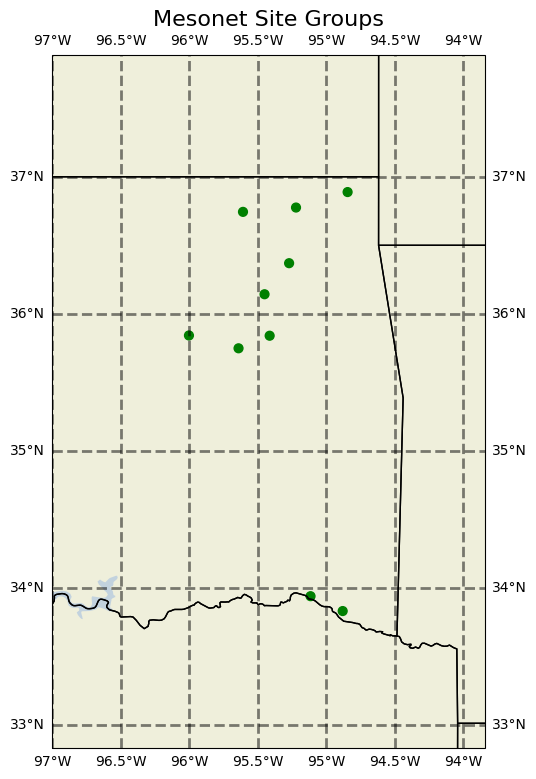

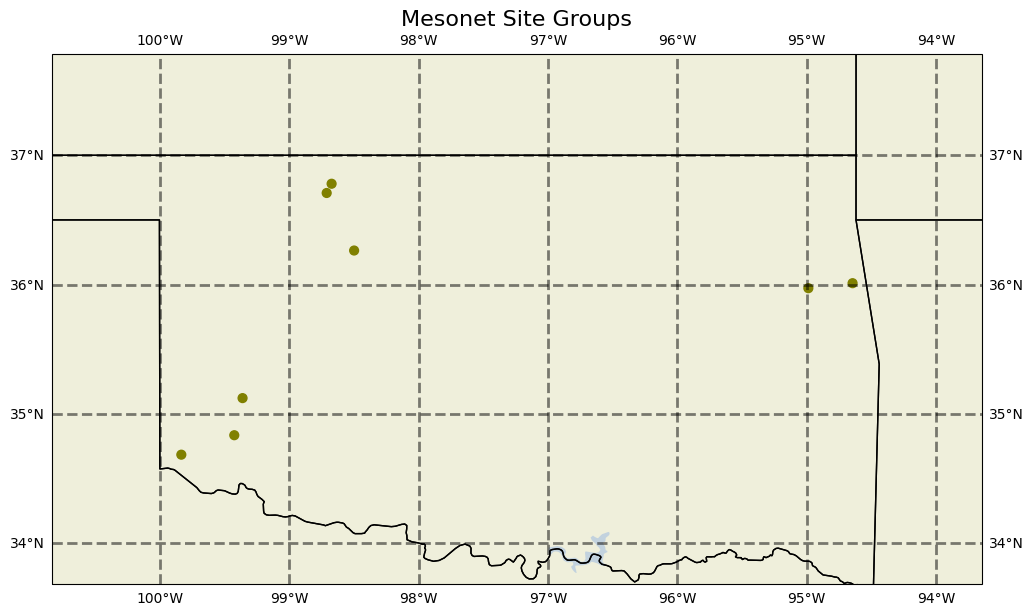

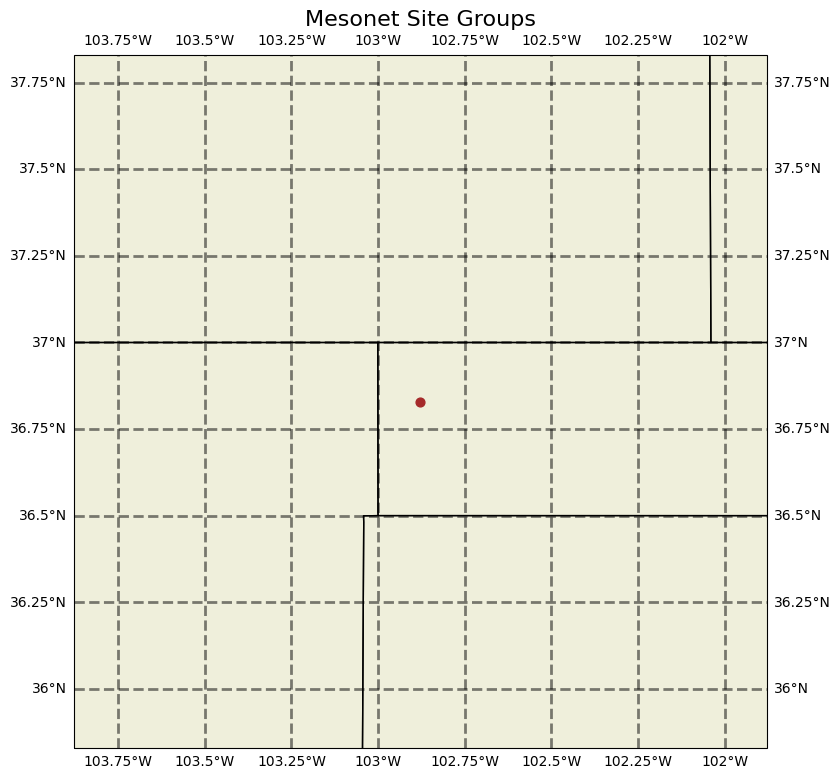

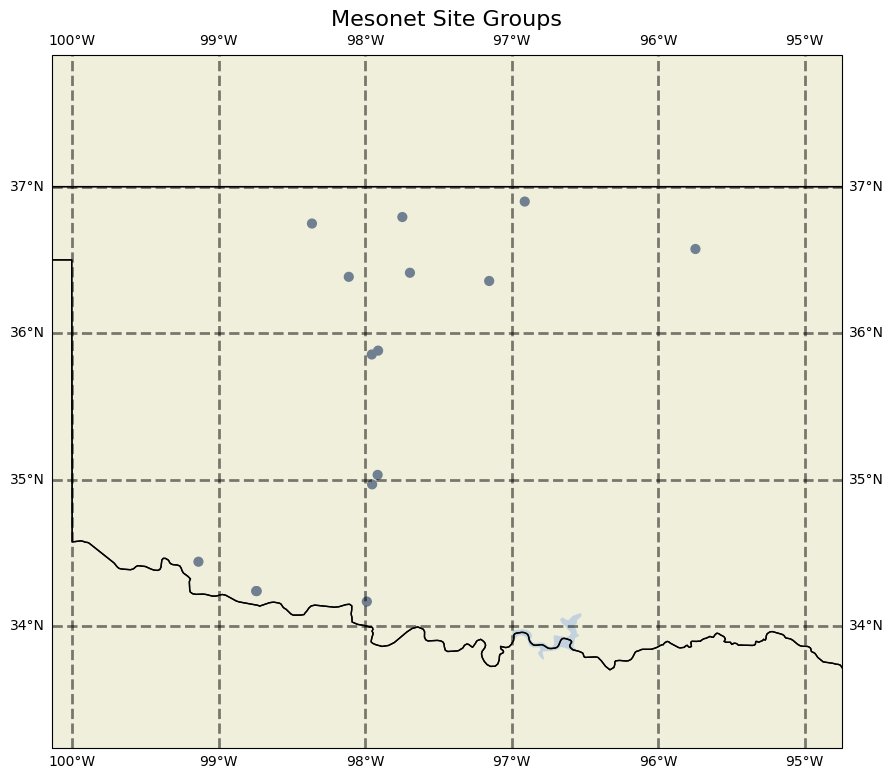

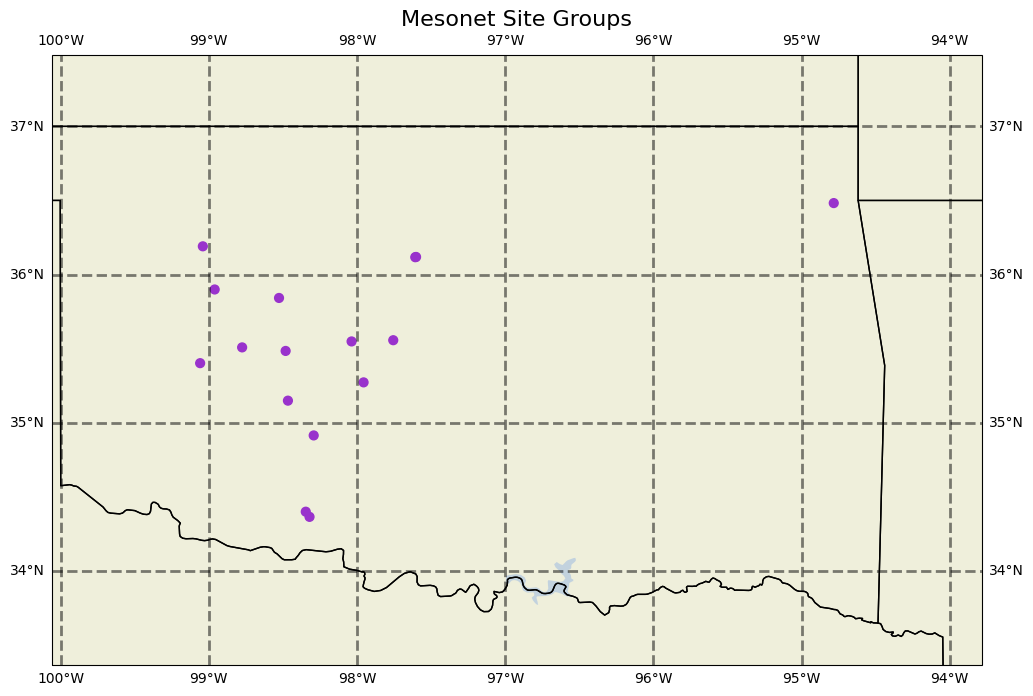

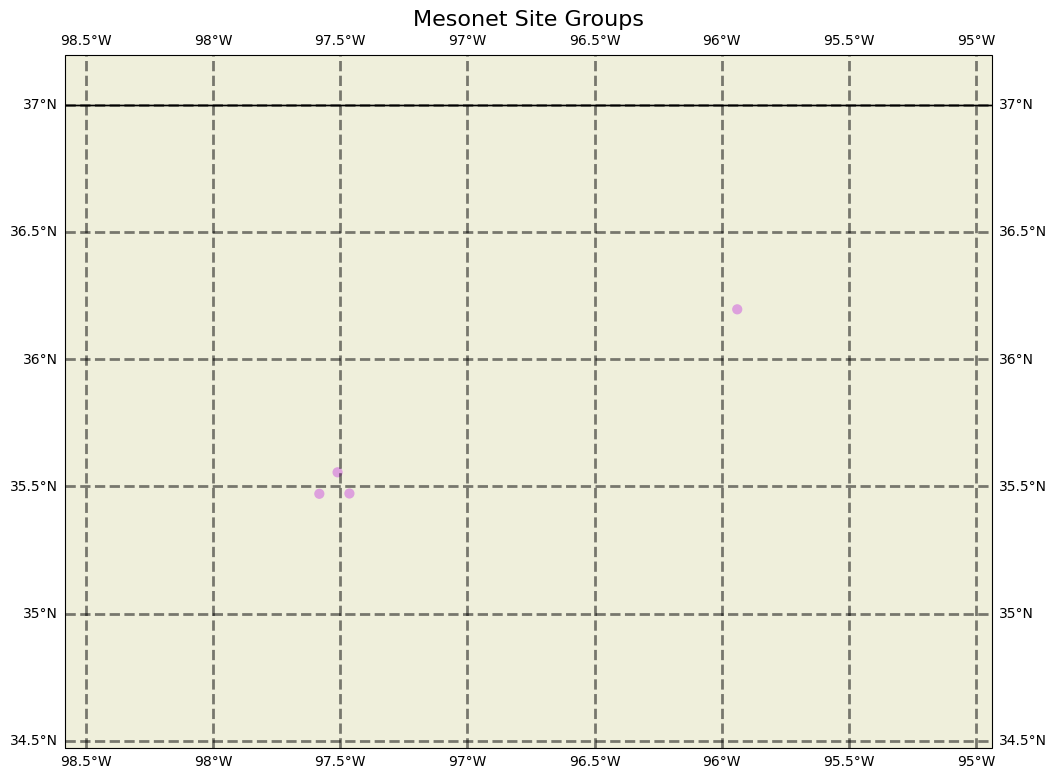

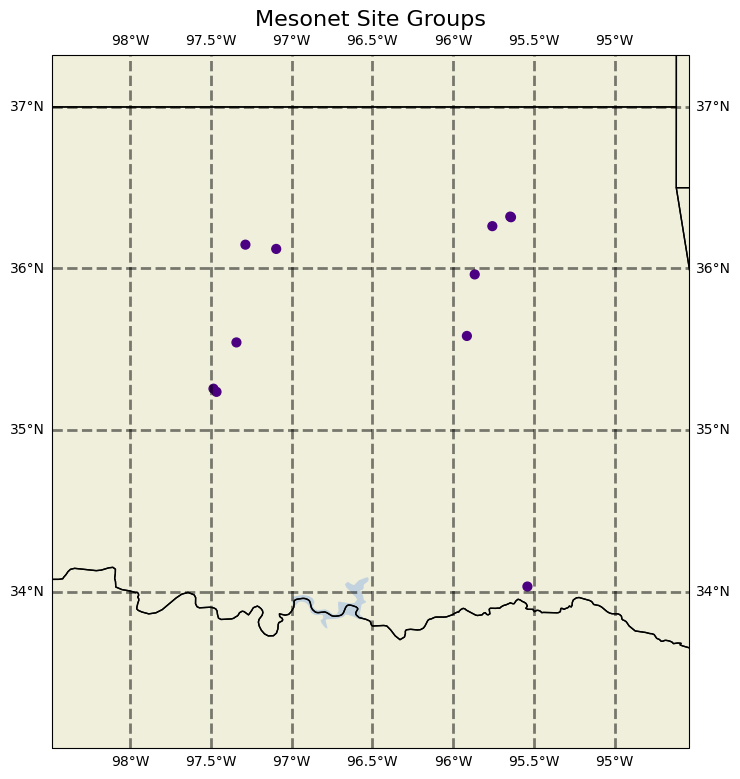

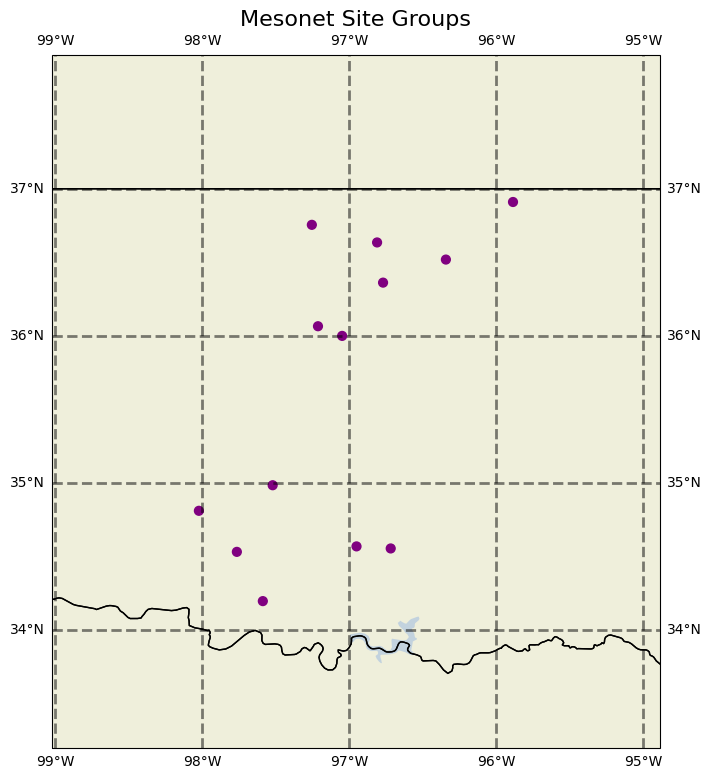

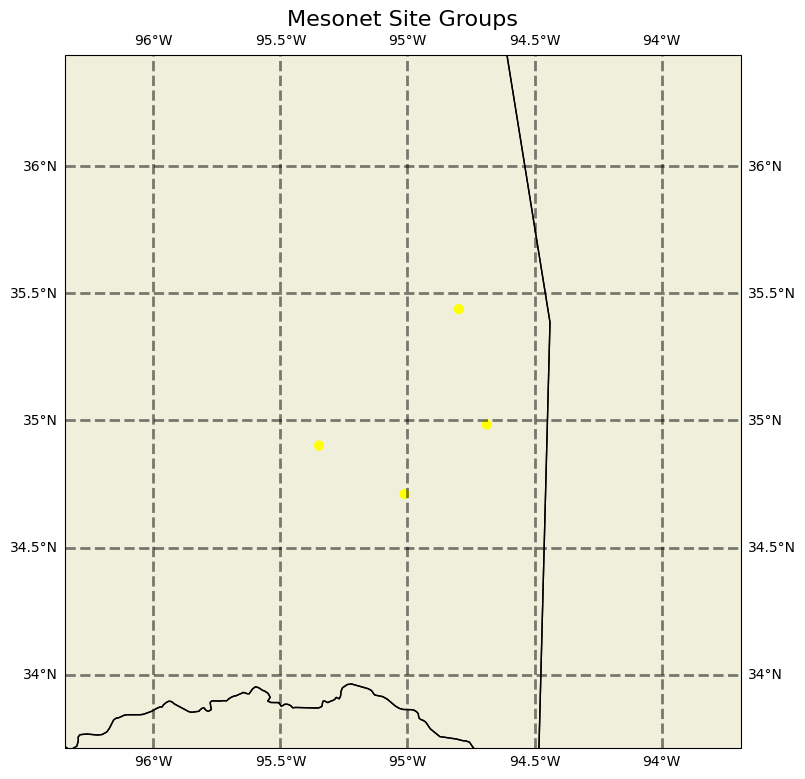

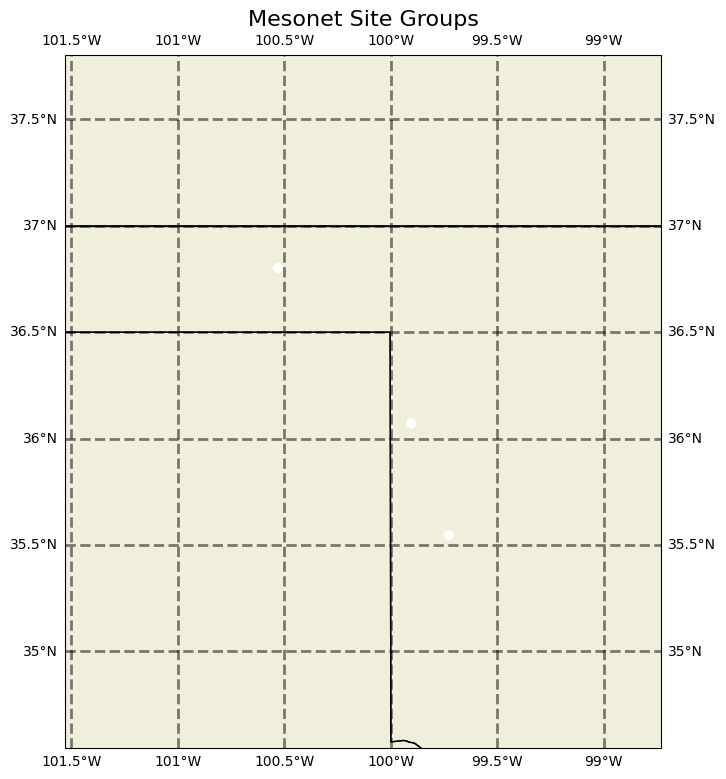

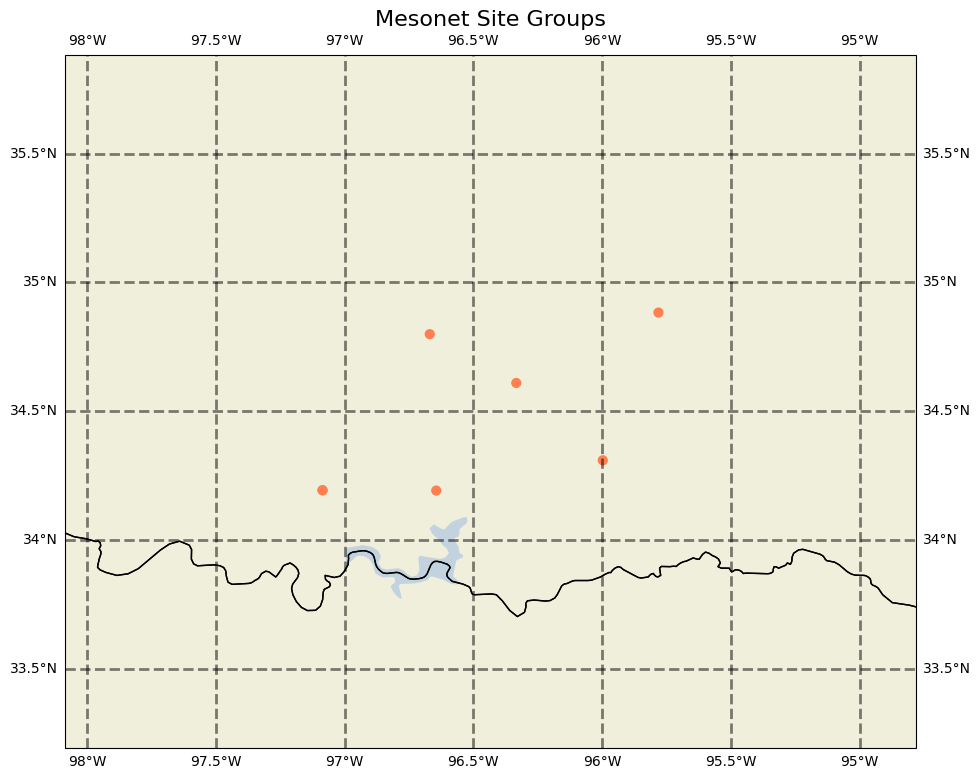

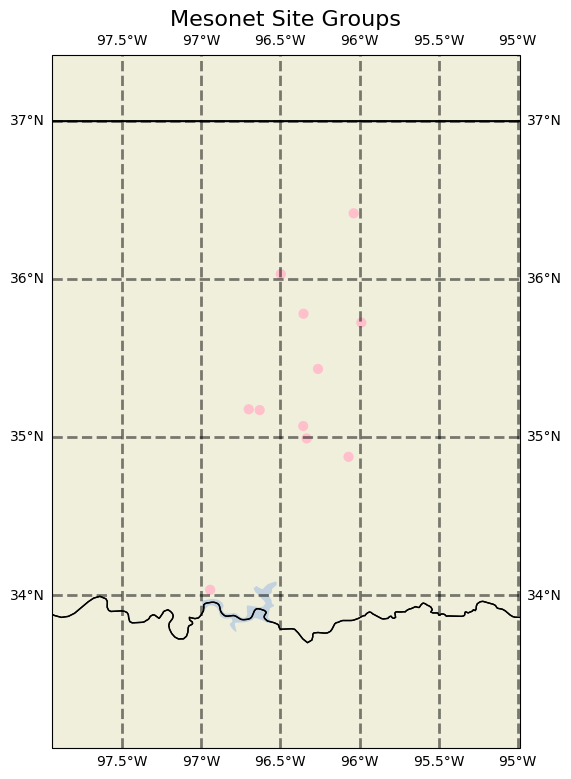

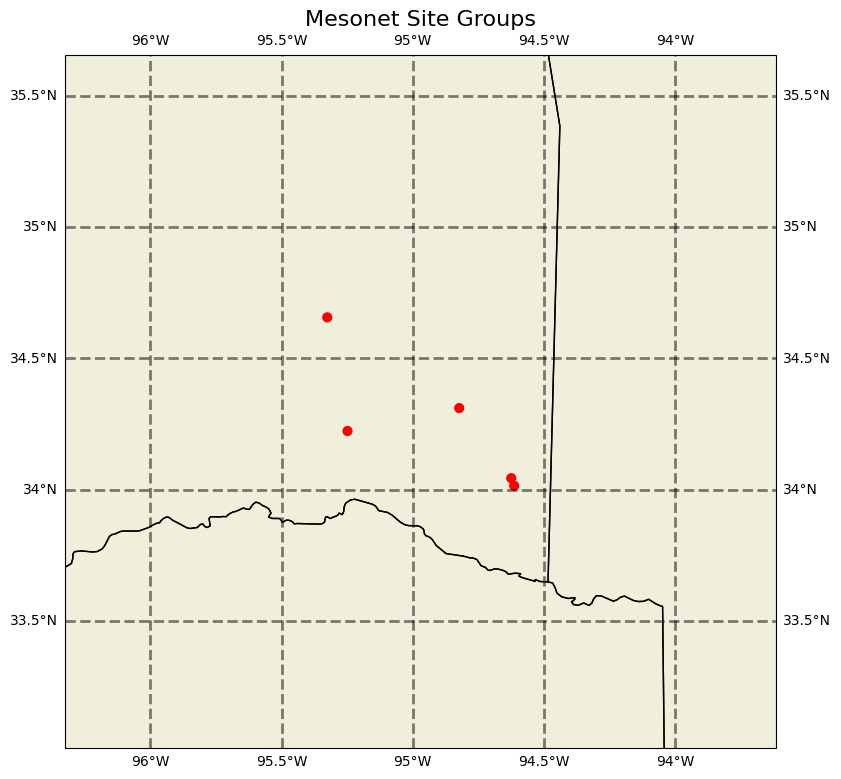

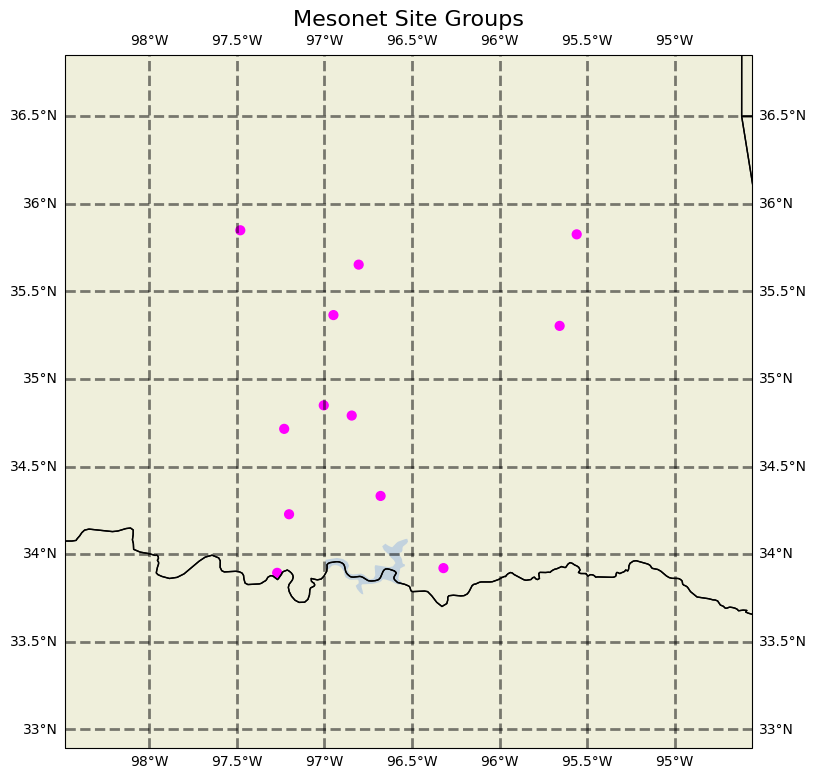

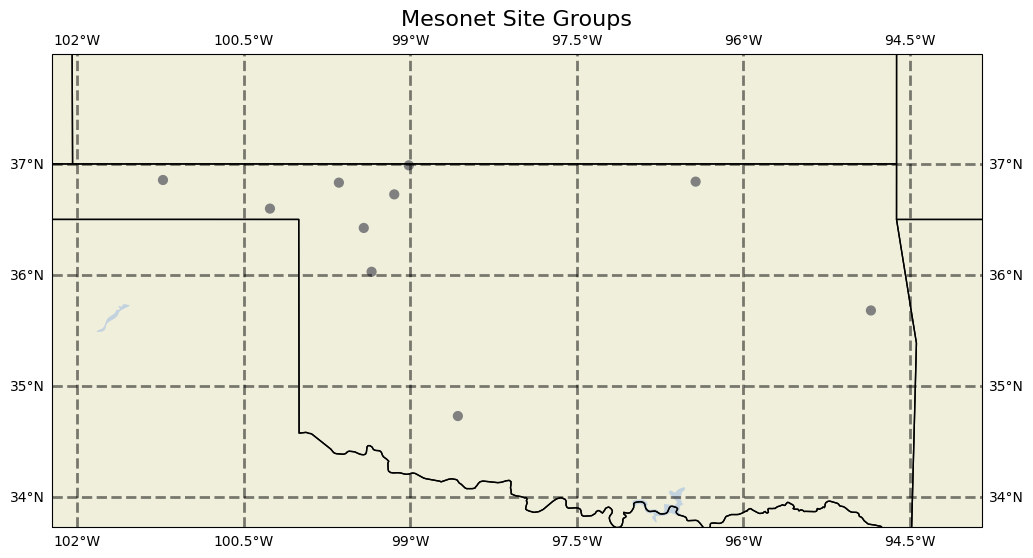

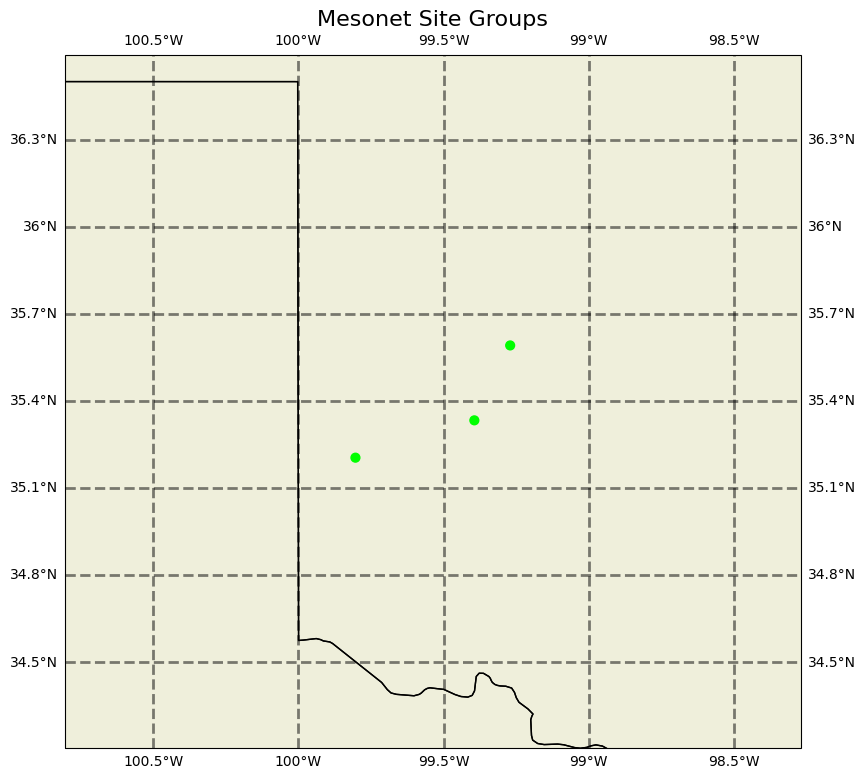

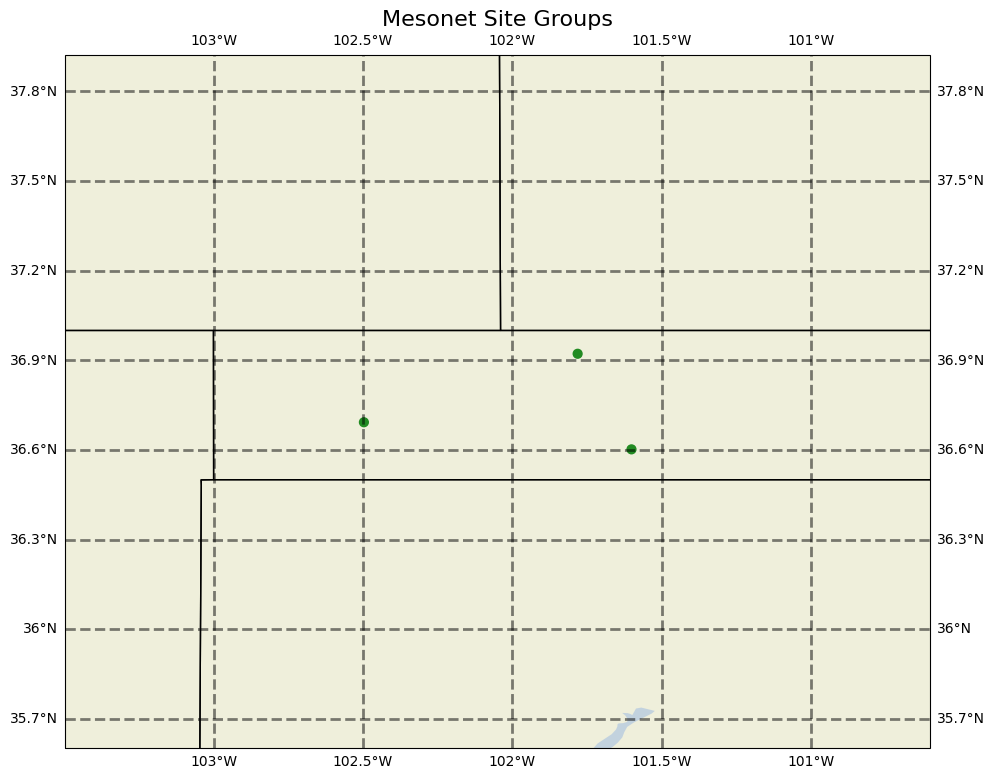

In [70]:
for n, _ in enumerate(dirs):
    df = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ok/aff/{dirs[n]}")
    plurality_plot(df)